# Homework 1 Part 2 - Solutions

This is an individual assignment.

---

Write your own code. You may repurpose any functions built during lecture. You may use ```scikit-learn``` functions.

---

In [3]:
# Import libraries and magics

import pandas as pd
import numpy as np
import numpy.linalg as la
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

---

# Exercise 1 (5 points)

In this question, you will practice how to use HiPerGator and Git to maintain your code.

1. (1 point) Open Open On-Demand [ood.rc.ufl.edu](ood.rc.ufl.edu) and create an interactive jupyter session with the following specifications: 2 CPU, 2 GPU (type = 'a100') and 4 GB of RAM. **Attach a screenshot of your jupyter notebook card, your gatorlink should be visible.**

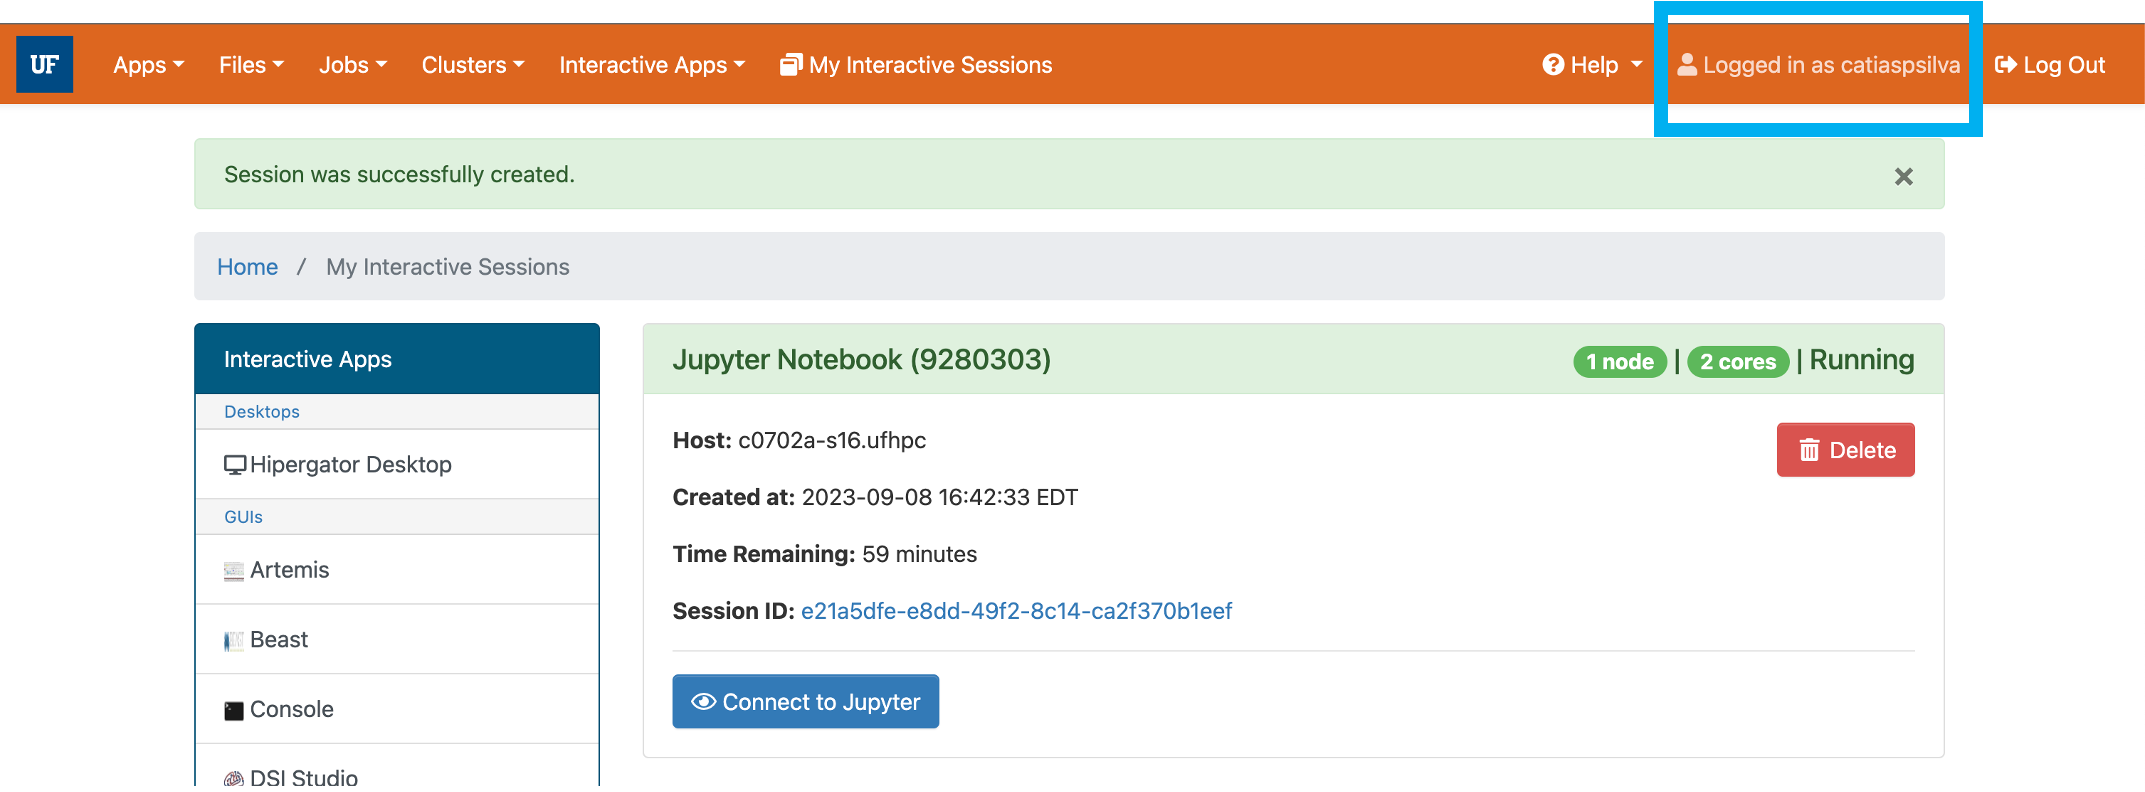

In [1]:
from IPython.display import Image
Image('figures/ood_rc.png', width=900)

2. (2 points) Create a symbolic link to map the class blue directory in your homepage. **Attach a screenshot to show that this link has been created.**

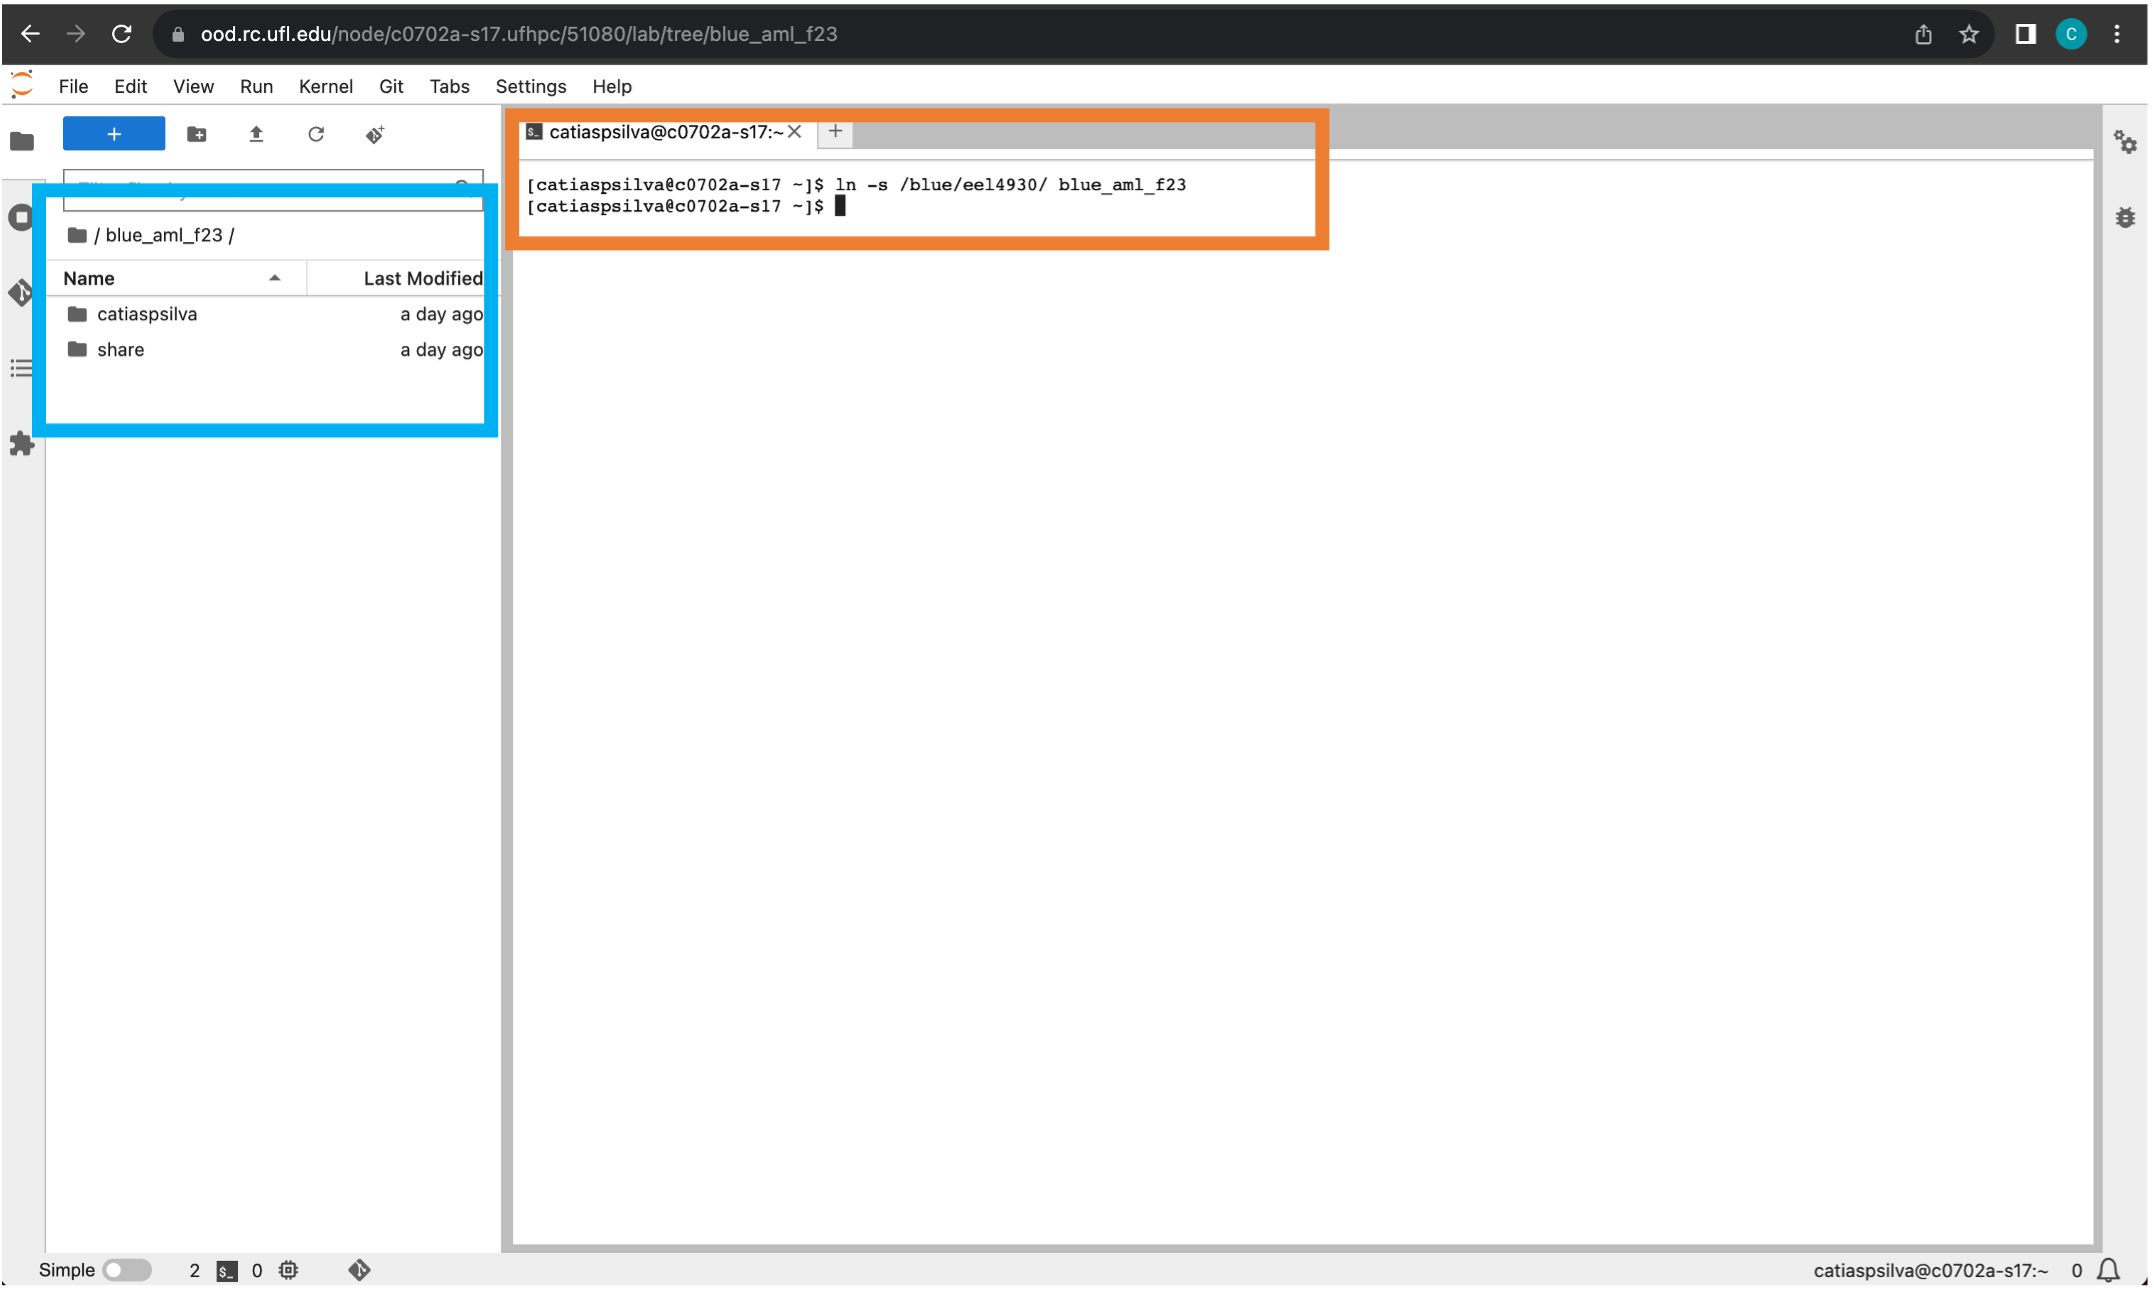

In [36]:
Image('figures/symbolic_link.png', width=900)

3. (2 points) Navigate to your folder within the symbolic link you just created. Clone the HW0 repository inside that folder - see the picture below. If you clone outside your personal and private folder (mine is blue_aml_f23/catiaspsilva), you will lose points. **Attach a screenshot.**

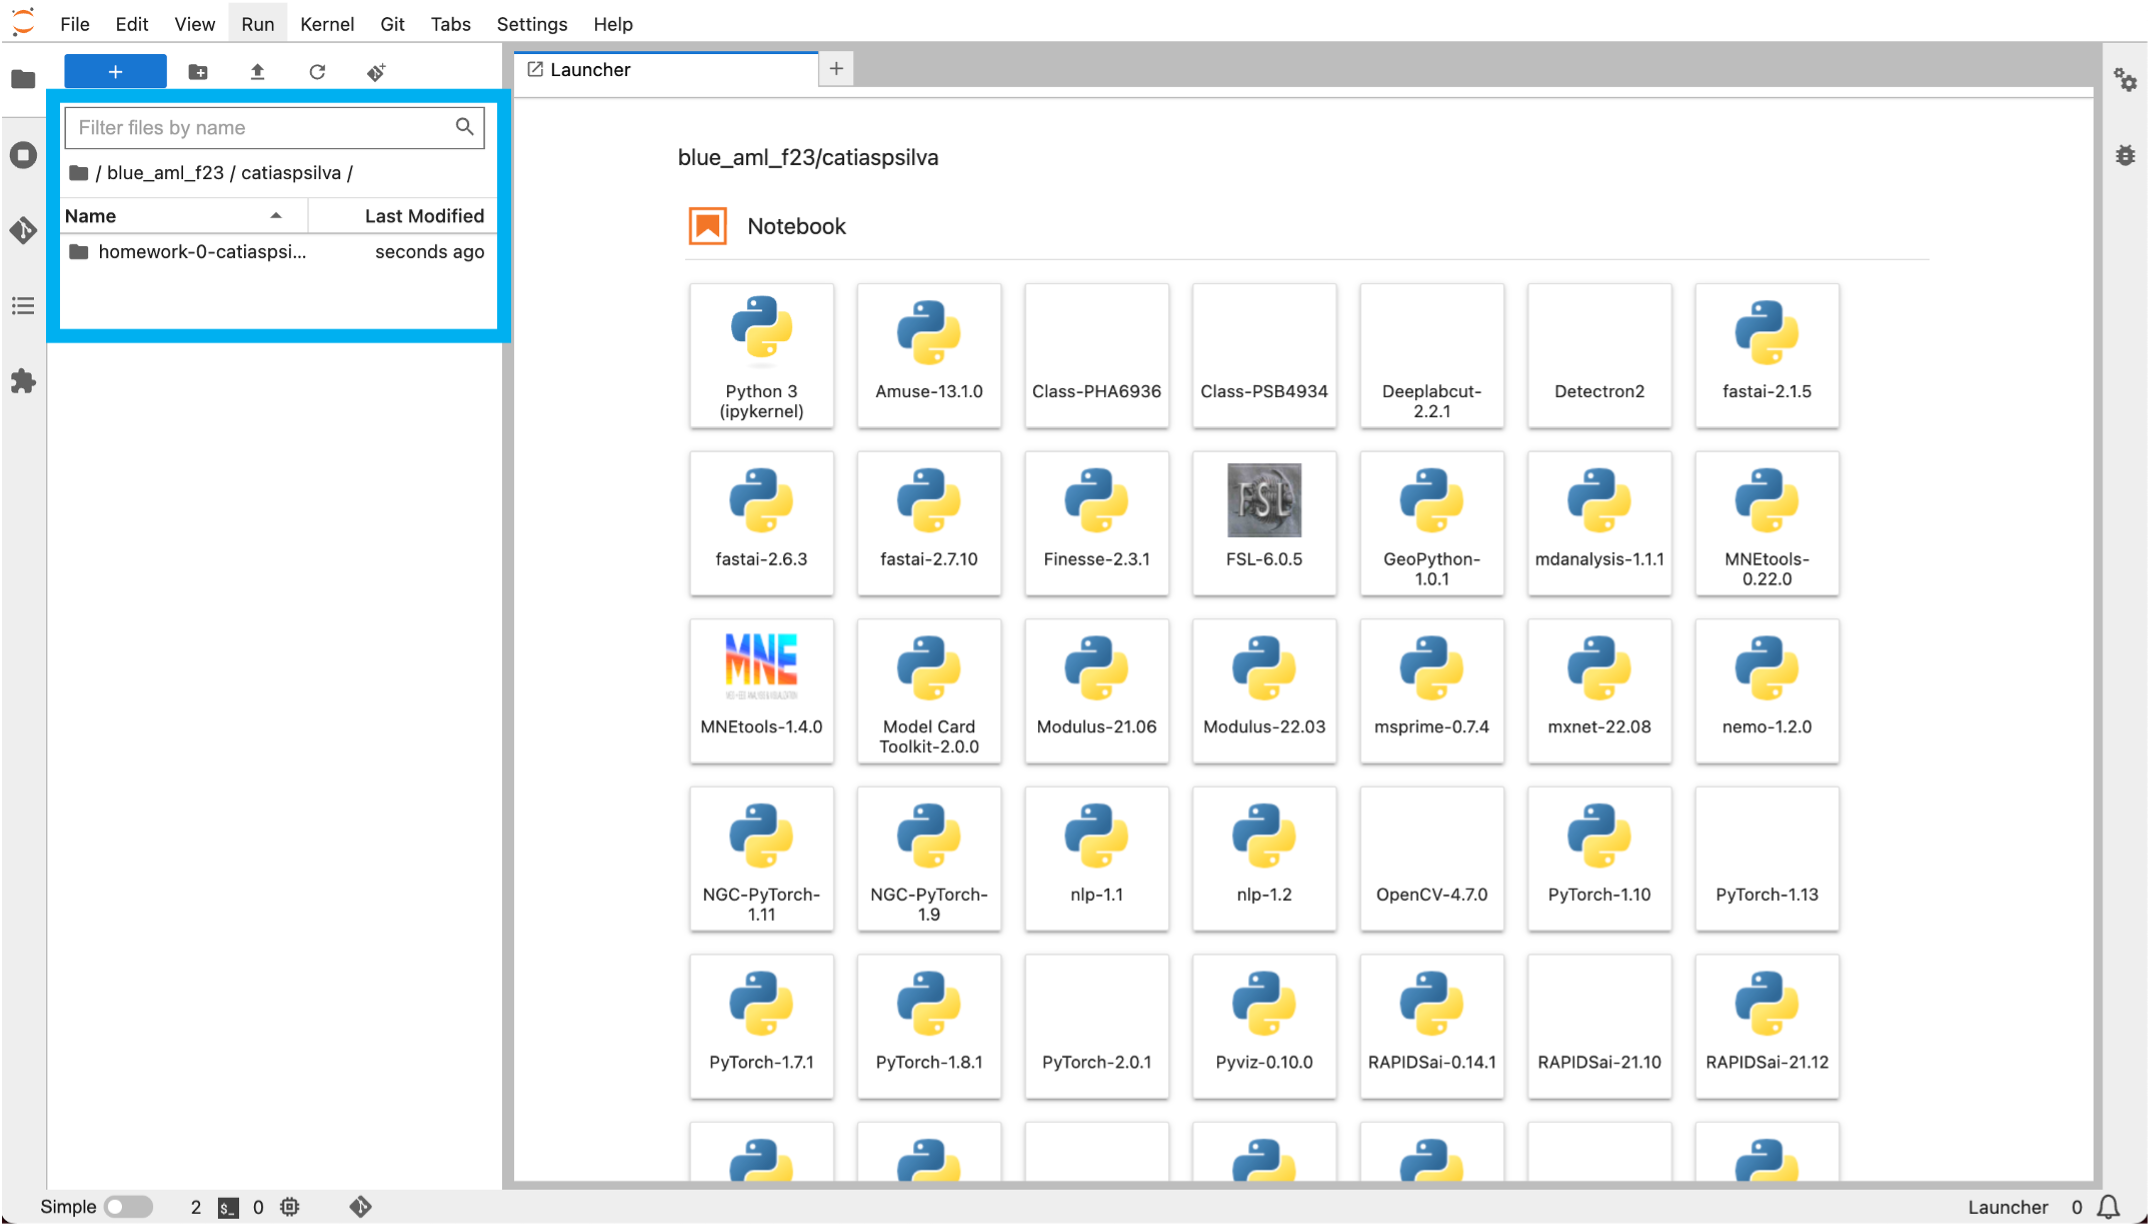

In [37]:
Image('figures/cloning_repo.png', width=900)

---

# Exercise 2 (20 points)

**Consider the noisy sinusoidal data we have been working with from lecture.**

**Build a linear regression model with Gaussian basis functions as feature representations of the data. Consider the Gaussian basis functions:**

\begin{align*}
\phi_j(x) = \exp\left\{-\frac{(x-\mu_j)^2)}{2\sigma^2}\right\}
\end{align*}

**where $\mu=\{0.1, 0.3, 0.6, 0.9\}$ for $j=1,2,3,4$, respectively, and a fixed standard deviation $\sigma=0.1$.**

1. (7 points) **Train this model using the training set generated below.**

2. (7 points) **Make predictions using the test set.**

3. (6 points) **Provide a paragraph discussion about how you would determine how many Gaussian basis functions you would need and how would you determine the mean values $\mu_j$ and the bandwidth parameter $\sigma$.**

In [21]:
def NoisySinusoidalData(N, a, b, sigma):
    '''Generates N data points in the range [a,b) sampled from a sin(2*pi*x) 
    with additive zero-mean Gaussian random noise with standard deviation sigma'''
    
    # N input samples, evenly spaced numbers between [a,b) incrementing by 1/N
    x = np.linspace(a,b,N)
    
    # draw N sampled from a univariate Gaussian distribution with mean 0, sigma standard deviation and N data points
    noise = np.random.normal(0,sigma,N)
    
    # desired values, noisy sinusoidal
    t = np.sin(2*np.pi*x) + noise
    
    return x, t

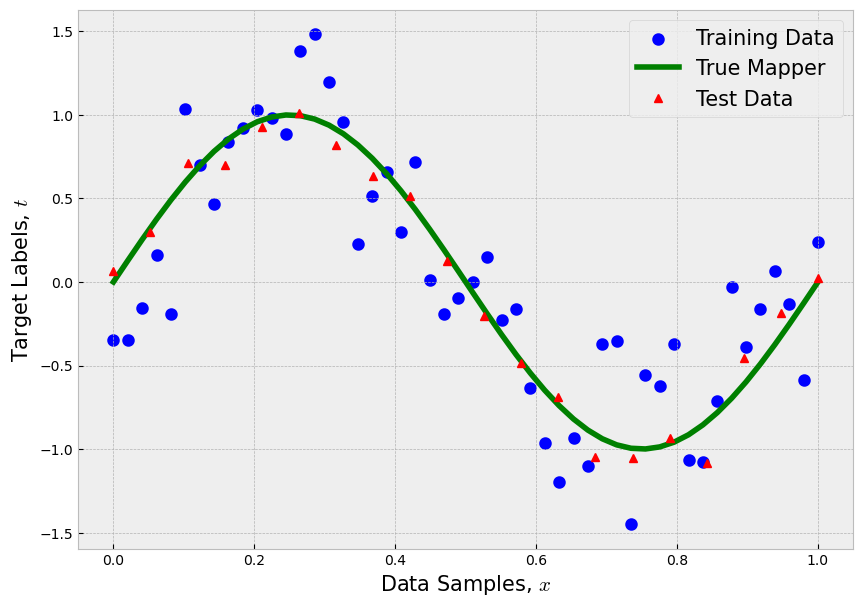

In [22]:
# Generate input samples and desired values
N_train = 50 # number of data samples for training
N_test = 20 # number of data samples for test

a, b = [0,1] # data samples interval

sigma_train = 0.4 # standard deviation of the zero-mean Gaussian noise -- training data
sigma_test = 0.1 # standard deviation of the zero-mean Gaussian noise -- test data

x_train, t_train = NoisySinusoidalData(N_train, a, b, sigma_train) # Training Data - Noisy sinusoidal
x_true, t_true = NoisySinusoidalData(N_train, a, b, 0) # True Sinusoidal - in practice, we don't have the true function
x_test, t_test = NoisySinusoidalData(N_test, a, b, sigma_test) # Test Data - Noisy sinusoidal

# Plotting
plt.figure(figsize=(10,7))
plt.scatter(x_train, t_train, c='b', linewidths=3, label = 'Training Data')
plt.plot(x_true, t_true, 'g', linewidth=4, label = 'True Mapper')
plt.plot(x_test, t_test, 'r^', label = 'Test Data')
plt.legend(fontsize=15)
plt.xlabel('Data Samples, $x$',size=15)
plt.ylabel('Target Labels, $t$',size=15);

In [23]:
sig = 0.1

# feature matrix
X = np.array([np.exp(-(x_train-mu)**2/(2*sig**2)) for mu in [0.1, 0.3, 0.6, 0.9]]).T

X.shape

(50, 4)

In [24]:
X = np.hstack((np.ones((X.shape[0],1)),X))

X.shape

(50, 5)

In [25]:
def GaussianRegression(x,t):
    '''Fit a polynomial of order M to the data input data x and desire values t'''
    
    # Compute feature matrix X with Gaussian basis functions features
    X = np.array([np.exp(-(x_train-mu)**2/(2*sig**2)) for mu in [0.1, 0.3, 0.6, 0.9]]).T 
    X = np.hstack((np.ones((X.shape[0],1)),X))
    #computes Gaussian basis functions
    
    # Compute the solution for the parameters w
    w = np.linalg.inv(X.T@X)@X.T@t # Optimal set of parameters w
    
    # Compute model prediction
    y = X@w
    
    return w, y

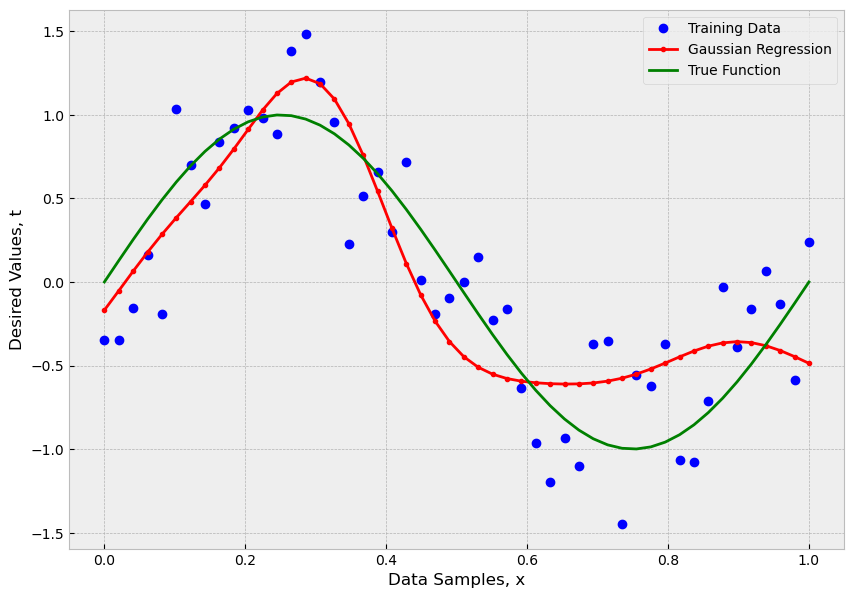

In [26]:
# Find the parameters that fit the noisy sinusoidal
w, y_train = GaussianRegression(x_train,t_train) 

plt.figure(figsize=(10,7))
plt.plot(x_train,t_train,'bo', label='Training Data')
plt.plot(x_train,y_train,'.-r', label = 'Gaussian Regression')
plt.plot(x_true,t_true,'g', label = 'True Function')
plt.legend()
plt.xlabel('Data Samples, x')
plt.ylabel('Desired Values, t');

---

### Extra Visualizations of the Gaussian Basis Functions

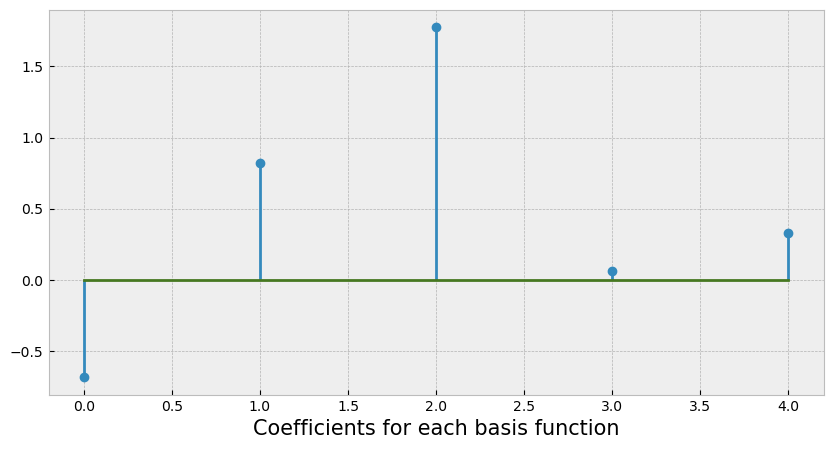

In [27]:
plt.figure(figsize=(10,5))
plt.stem(w)
plt.xlabel('Coefficients for each basis function',size=15);

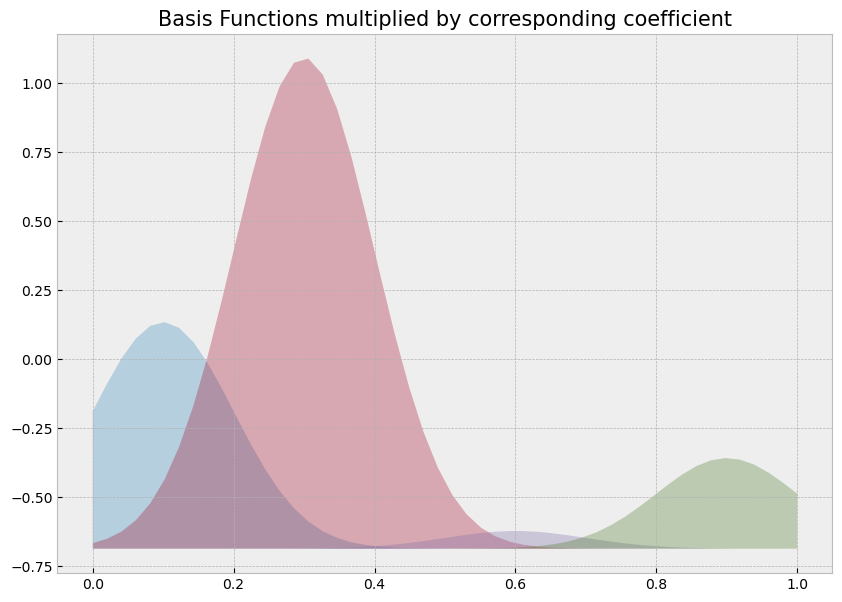

In [28]:
# Parameters for Gaussian Basis Functions
mu_vals=[0.1, 0.3, 0.6, 0.9]
sig=0.1

# Lambda function to create Gaussian basis function
gauss_basis=lambda x, mu, sig: np.exp(-(x-mu)**2/(2*sig**2))

plt.figure(figsize=(10,7))
for i in range(len(mu_vals)):
    plt.fill_between(x_train, w[i+1]*gauss_basis(x_train,mu_vals[i],sig)+w[0], w[0],alpha=0.3)
    plt.title('Basis Functions multiplied by corresponding coefficient',size=15);

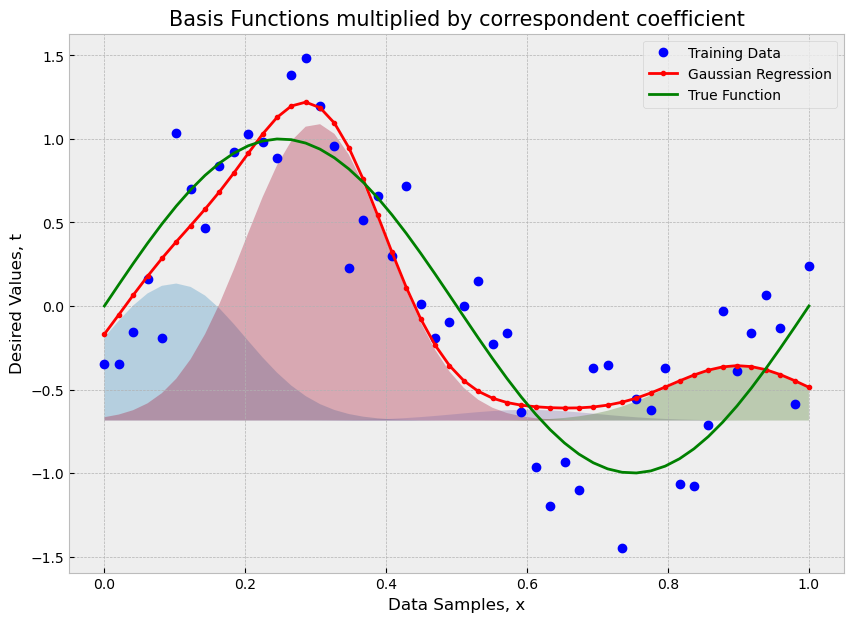

In [29]:
plt.figure(figsize=(10,7))
plt.plot(x_train,t_train,'bo', label='Training Data')
plt.plot(x_train,y_train,'.-r', label = 'Gaussian Regression')
plt.plot(x_true,t_true,'g', label = 'True Function')
for i in range(len(mu_vals)):
    plt.fill_between(x_train, w[i+1]*gauss_basis(x_train,mu_vals[i],sig)+w[0], w[0],alpha=0.3)
    plt.title('Basis Functions multiplied by correspondent coefficient',size=15);
plt.legend()
plt.xlabel('Data Samples, x')
plt.ylabel('Desired Values, t');

---

In [30]:
def GaussianRegression_test(x,w):
    # Feature matrix for test set
    X = np.array([np.exp(-(x-mu)**2/(2*sig**2)) for mu in [0.1, 0.3, 0.6, 0.9]]).T 
    X = np.hstack((np.ones((X.shape[0],1)),X))
    #computes Gaussian basis functions
    
    # Prediction for test set
    y = X@w
    
    return y

In [31]:
y_test = GaussianRegression_test(x_test, w)

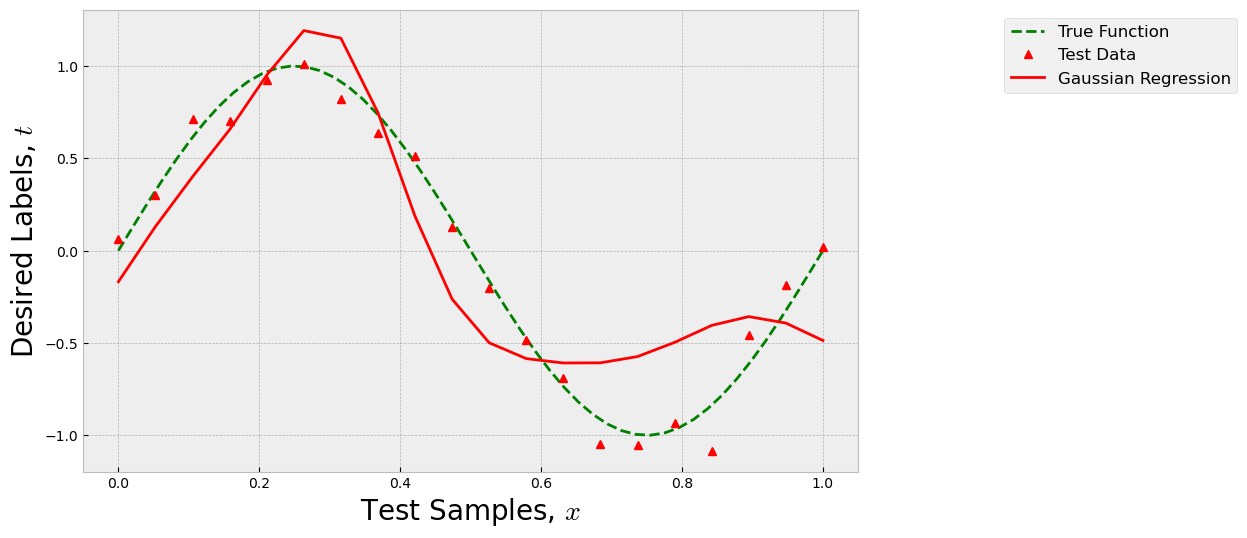

In [32]:
# Plotting
fig=plt.figure(figsize=(10,6))
plt.plot(x_true, t_true, '--g', label = 'True Function')
plt.plot(x_test, t_test, 'r^', label = 'Test Data')
plt.plot(x_test, y_test,'r', label = 'Gaussian Regression')
plt.legend(bbox_to_anchor=(1.5, 1),fontsize=12,ncol=1)
plt.xlabel('Test Samples, $x$', fontsize=20)
plt.ylabel('Desired Labels, $t$', fontsize=20);

---

# Exercise 3 (20 points)

**Consider the diabetes data:**

In [33]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes(return_X_y=False)
# print(diabetes.DESCR)

**This dataset is already described in the _feature space_. Each input sample $x_i$ is described as 10-dimensional feature vctor $\phi(x_i)$. The features correspond to: age, sex, bmi, bp, s1, s2, s3, s4, s5 and s6 measurements (read the description above for more details). The target variable corresponds a measure of diabetes disease progression one year after baseline.**

**Let's load the data as a ```pandas``` dataframe:**

In [34]:
import numpy as np

df_diabetes = pd.DataFrame(data=np.hstack((diabetes.target[:,np.newaxis],diabetes.data)), 
                  columns=['Target']+diabetes.feature_names)

df_diabetes

,Target,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,151.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,75.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,141.0,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,206.0,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,135.0,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...,...
437,178.0,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,104.0,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,132.0,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,220.0,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [35]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  442 non-null    float64
 1   age     442 non-null    float64
 2   sex     442 non-null    float64
 3   bmi     442 non-null    float64
 4   bp      442 non-null    float64
 5   s1      442 non-null    float64
 6   s2      442 non-null    float64
 7   s3      442 non-null    float64
 8   s4      442 non-null    float64
 9   s5      442 non-null    float64
 10  s6      442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


**The goal is to fit a linear regression model on the provided features, i.e., the model is of the form:**

$$y(x) = w_0 + w_1\phi_1(x) + w_2\phi_2(x) + w_3\phi_3(x) + \dots + w_{10}\phi_{10}(x)$$

**where $w_0$ is the bias (or intercept) coefficient and all other $w_i, i=1,\dots,10$ correspond to the coefficient associated with feature $\phi_i$ (age, sex, bmi, bp, etc.).**

**Answer the following questions:**

1. (2 points) **Randomly partition the data into training (70%) and test sets (30%) with a fixed random seed generator.**

2. (6 points) **Use a 5-fold cross-validation strategy to determine the hyperparameter values to fit a linear regression model with ridge regularization for this dataset. Show and document your work.**

3. (4 points) **Evaluate performance in the test set.**

4. (4 points) **Determine the final value for the intercept and coefficients of the linear regression model. Plot all 11 values as a ```stem``` plot.**

5. (4 points) **Based on this plot, which input variable (also referred to the independent variable) has the most contribution for predicting the target variable (also referred to the dependent variable)?**

In [36]:
# Problem 1

from sklearn.model_selection import train_test_split

# Partition the data into training/test sets
train, test = train_test_split(df_diabetes, 
                               test_size=0.3, 
                               shuffle=True,
                              random_state=42)

In [37]:
train

,Target,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
225,208.0,0.030811,0.050680,0.032595,0.049415,-0.040096,-0.043589,-0.069172,0.034309,0.063015,0.003064
412,261.0,0.074401,-0.044642,0.085408,0.063187,0.014942,0.013091,0.015505,-0.002592,0.006207,0.085907
118,179.0,-0.056370,0.050680,-0.010517,0.025315,0.023198,0.040022,-0.039719,0.034309,0.020609,0.056912
114,258.0,0.023546,-0.044642,0.110198,0.063187,0.013567,-0.032942,-0.024993,0.020655,0.099241,0.023775
364,262.0,0.001751,0.050680,-0.006206,-0.019442,-0.009825,0.004949,-0.039719,0.034309,0.014821,0.098333
...,...,...,...,...,...,...,...,...,...,...,...
106,134.0,-0.096328,-0.044642,-0.076264,-0.043542,-0.045599,-0.034821,0.008142,-0.039493,-0.059471,-0.083920
270,202.0,0.005383,0.050680,0.030440,0.083844,-0.037344,-0.047347,0.015505,-0.039493,0.008641,0.015491
348,148.0,0.030811,-0.044642,-0.020218,-0.005670,-0.004321,-0.029497,0.078093,-0.039493,-0.010903,-0.001078
435,64.0,-0.012780,-0.044642,-0.023451,-0.040099,-0.016704,0.004636,-0.017629,-0.002592,-0.038460,-0.038357


In [38]:
test

,Target,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
287,219.0,0.045341,-0.044642,-0.006206,-0.015999,0.125019,0.125198,0.019187,0.034309,0.032432,-0.005220
211,70.0,0.092564,-0.044642,0.036907,0.021872,-0.024960,-0.016658,0.000779,-0.039493,-0.022517,-0.021788
72,202.0,0.063504,0.050680,-0.004050,-0.012556,0.103003,0.048790,0.056003,-0.002592,0.084492,-0.017646
321,230.0,0.096197,-0.044642,0.051996,0.079265,0.054845,0.036577,-0.076536,0.141322,0.098648,0.061054
73,111.0,0.012648,0.050680,-0.020218,-0.002228,0.038334,0.053174,-0.006584,0.034309,-0.005142,-0.009362
...,...,...,...,...,...,...,...,...,...,...,...
238,257.0,0.034443,0.050680,-0.009439,0.059744,-0.035968,-0.007577,-0.076536,0.071210,0.011011,-0.021788
26,137.0,-0.107226,-0.044642,-0.077342,-0.026328,-0.089630,-0.096198,0.026550,-0.076395,-0.042571,-0.005220
7,63.0,0.063504,0.050680,-0.001895,0.066629,0.090620,0.108914,0.022869,0.017703,-0.035816,0.003064
401,93.0,0.016281,-0.044642,-0.045007,-0.057313,-0.034592,-0.053923,0.074412,-0.076395,-0.042571,0.040343


In [39]:
# Extract training data and labels into 2 variables for both training and test sets

X_train = train[train.columns[1:]].to_numpy()
t_train = train['Target'].to_numpy()

X_test = test[test.columns[1:]].to_numpy()
t_test = test['Target'].to_numpy()

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((309, 10), (309,), (133, 10), (133,))

In [40]:
# Scale the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [41]:
# Appending the bias column (vector of 1s) to the feature matrix

X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))

X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))

X_train.shape, X_test.shape

((309, 11), (133, 11))

In [42]:
## Helper functions

def RidgeRegression(X,t,lam):
    '''Fit a ridge regression model on provided feature matrix X and target vector t'''
    # Compute the solution for the parameters w
    w = np.linalg.inv(X.T@X + lam*np.eye(X.shape[1]))@X.T@t
    # Compute model prediction
    y = X@w
    return w, y

def LinearRegression_test(X,w):
    '''Linear regression model prediction'''
    # Prediction for test set
    y = X@w
    
    return y

In [43]:
# Problem 2

from sklearn.model_selection import KFold

# Set of values for lambda to explore
lam_vals= np.arange(0.01,1.1,0.01)

# Cross-validation object
k = 5 # number of folds
kf = KFold(n_splits=k,shuffle=True)

# Initialize parameters
min_mse = 10**10
lam_best = 0

for lam in lam_vals:
#     print('Lambda Value = ',lam)

    # For each training/validation split
    f=1

    #initialize performance measures
    MSE_train_avg,MSE_val_avg = 0, 0

    for train_index, validation_index in kf.split(X_train):
#         print('\nFold ',f)

        # Select training set using the indices found from kf.split
        X_train2, X_validation = X_train[train_index], X_train[validation_index]

        # Select validation set using the indices found from kf.split
        t_train2, t_validation = t_train[train_index], t_train[validation_index]

        # Training model with training set
        w, y_train = RidgeRegression(X_train2, t_train2, lam)

        # Evaluate trained model in validation set
        y_val = LinearRegression_test(X_validation, w)

        # Performance Measure
        MSE_train = np.mean((t_train2-y_train)**2)
        MSE_val   = np.mean((t_validation-y_val)**2)

        # Average performance measure
        MSE_train_avg = MSE_train_avg+MSE_train
        MSE_val_avg = MSE_val_avg+MSE_val
#         print('MSE Training = ', MSE_train)
#         print('MSE Validation = ', MSE_val)
        f+=1

#     print('\nAverage Performance in Training = ', MSE_train_avg/k)
#     print('Average Performance in Validation = ', MSE_val_avg/k)
#     print('-----------------------------------------------------\n')
    
    if MSE_val_avg/k < min_mse:
        lam_best = lam
        min_mse = MSE_val_avg/k
        
print('The lambda chosen is ' + str(lam_best) + ', with an average MSE value of ' + str(min_mse))

The lambda chosen is 0.33, with an average MSE value of 3029.8798431908845


In [45]:
# Train the final model

w, y_train = RidgeRegression(X_train, t_train, lam_best)

In [46]:
# Problem 3

# Evaluate the model in test set

y_test = LinearRegression_test(X_test, w)

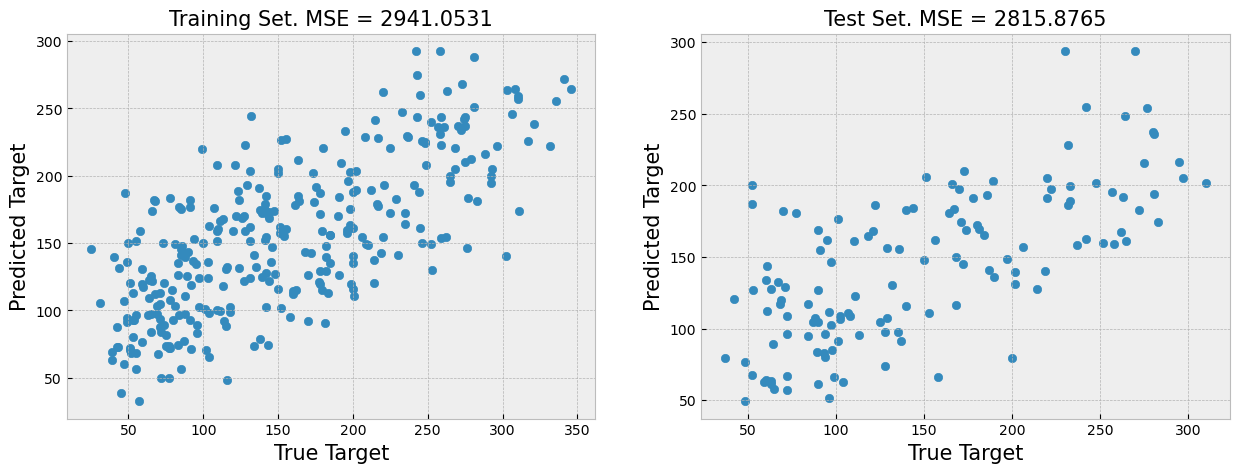

In [47]:
# Evaluate performance in train/test sets
MSE_train = np.mean((t_train-y_train)**2)
MSE_test = np.mean((t_test-y_test)**2)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(t_train, y_train)
plt.title('Training Set. MSE = '+str(np.round(MSE_train,4)), size=15)
plt.xlabel('True Target', size=15); plt.ylabel('Predicted Target', size=15)
plt.subplot(1,2,2)
plt.scatter(t_test, y_test)
plt.xlabel('True Target', size=15); plt.ylabel('Predicted Target', size=15)
plt.title('Test Set. MSE = '+str(np.round(MSE_test,4)), size=15);

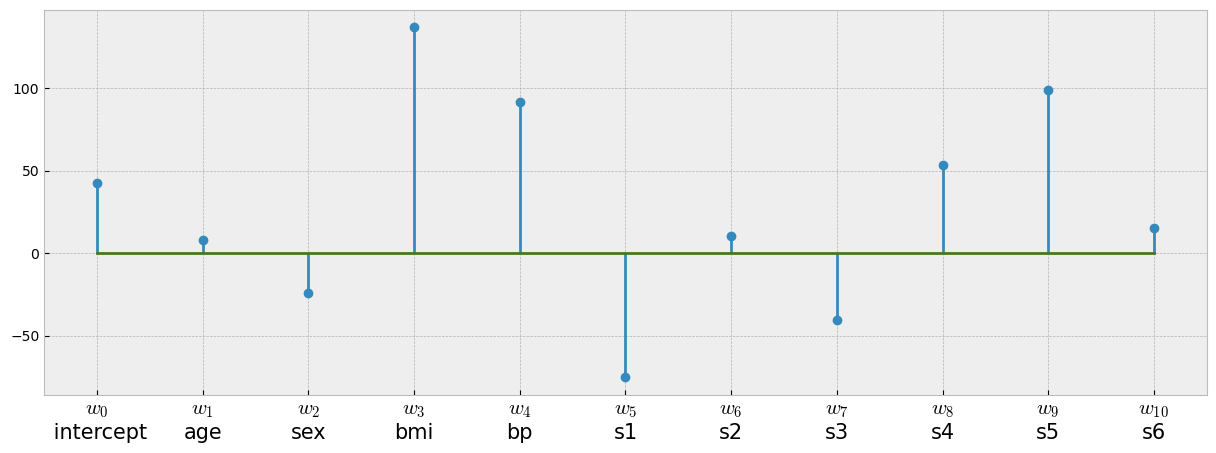

In [48]:
plt.figure(figsize=(15,5))
plt.stem(w)
plt.xticks(range(len(w)), ['$w_0$\n intercept']+
           ['$w_{'+str(x)+'}$\n'+df_diabetes.columns[x] for x in range(1,len(w))], size=15);

Based on this plot, we can see that the feature bmi and s5 (followed by bp, s1 and s4) have the largest coefficient (in the absolute sense), thus they contribute the most to the model prediction.

---

# On-Time (5 points)

Submit your assignment before the deadline.

___

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___